In [1]:
# Training 
#- Use this notebook to train a model for a specific organelle - brightfield to fluorescence 
#- insert the path prefix for the github project directory in "main_path"
#- choose the organelle to predict
#- choose how many patches from the BF folder you want to predict


In [2]:
main_path = "/.../Github/" ## change to main directory of the github project
organelle = 'NucEnv' # # NucEnv , Nuclioli , DNAmito , ER , AF , Mito , Membrane , Micro , TJ
Nimgs = 5 ## how many patches to load

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import r2_score, explained_variance_score
import matplotlib.pyplot as plt
import cv2
import random
from functools import partial
import tifffile

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.autograd import Function
from torch import einsum
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

from generative.inferers import DiffusionInferer
from generative.networks.nets.diffusion_model_unet import DiffusionModelUNet # Adapted from https://github.com/huggingface/diffusers
from generative.networks.schedulers.ddpm import DDPMScheduler
from generative.networks.schedulers import DDIMScheduler
from generative.metrics import FIDMetric, MMDMetric, MultiScaleSSIMMetric, SSIMMetric

import sys
sys.path.append('/.../Github/src') # home/odedrot/In_silico_labelling_BF
from ProcessingFunctions import segmentation_pipeline, seg_metrics, run_augmentations, create_random_3Dpatches
from Params import SegmentationParams
from DisplayFunctions import display_images, volumetric2sequence
from LoadSaveFunctions import load_patches, LoadModel, save_patches
from PredictFL import predict_FL
from MetricsFunctions import pcc, mse, jsd, mi, ms_ssim


In [7]:
print(torch.__version__)

2.2.0+cu121


In [8]:
seg_params = SegmentationParams(organelle)
device = torch.device("cuda") 
DiffModel = LoadModel(main_path, organelle, load_model=0, timesteps=1000)
model = DiffModel.model.to(device)

In [9]:
## load train patches
BF_images = load_patches(main_path, organelle, 'BF', Nimgs) # (5, 16, 64, 64) 0-1
GT_images = load_patches(main_path, organelle, 'GT', Nimgs) # (5, 16, 64, 64)
BF_images = torch.tensor(BF_images, dtype=torch.float32).unsqueeze(1).permute(0,1,3,4,2)
GT_images = torch.tensor(GT_images, dtype=torch.float32).unsqueeze(1).permute(0,1,3,4,2)
print(BF_images.shape, BF_images.dtype)
print(GT_images.shape, GT_images.dtype)

## load test patches
BFbatch_val                = load_patches(main_path, organelle, 'BF', Nimgs) # (5, 16, 64, 64) 0-1
FLbatch_val                = load_patches(main_path, organelle, 'GT', Nimgs) # (5, 16, 64, 64)
BFbatch_val = torch.tensor(BFbatch_val, dtype=torch.float32).unsqueeze(1).permute(0,1,3,4,2)
FLbatch_val = torch.tensor(FLbatch_val, dtype=torch.float32).unsqueeze(1).permute(0,1,3,4,2)
FLbatch_val = FLbatch_val.numpy()
print(BFbatch_val.shape, BFbatch_val.dtype)
print(BFbatch_val.shape, FLbatch_val.dtype)
print('BFbatch_val  ' , BFbatch_val.min(), BFbatch_val.max(), BFbatch_val.mean(), BFbatch_val.std())
print('FLbatch_val  ' , FLbatch_val.min(), FLbatch_val.max(), FLbatch_val.mean(), FLbatch_val.std())

torch.Size([5, 1, 64, 64, 16]) torch.float32
torch.Size([5, 1, 64, 64, 16]) torch.float32
torch.Size([5, 1, 64, 64, 16]) torch.float32
torch.Size([5, 1, 64, 64, 16]) float32
BFbatch_val   tensor(0.) tensor(0.9882) tensor(0.3139) tensor(0.1851)
FLbatch_val   0.0 1.0 0.16255184 0.15937072


/tmp/ipykernel_1088480/2879427598.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  display_images(torch.tensor(BFbatch_val)[:,0,:,:,0], 1,5, range(5))


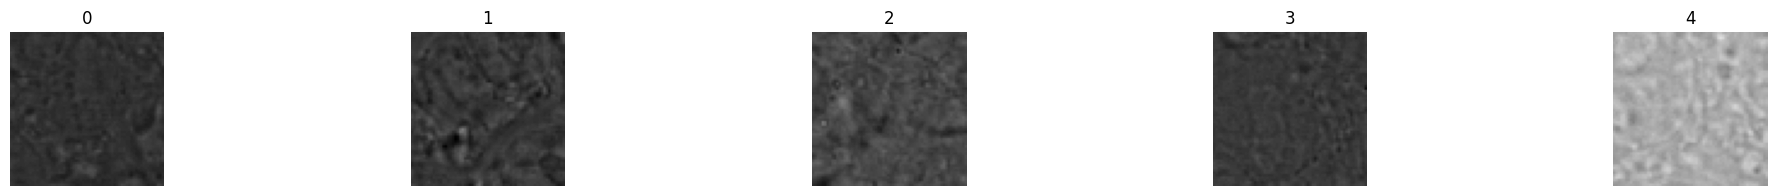

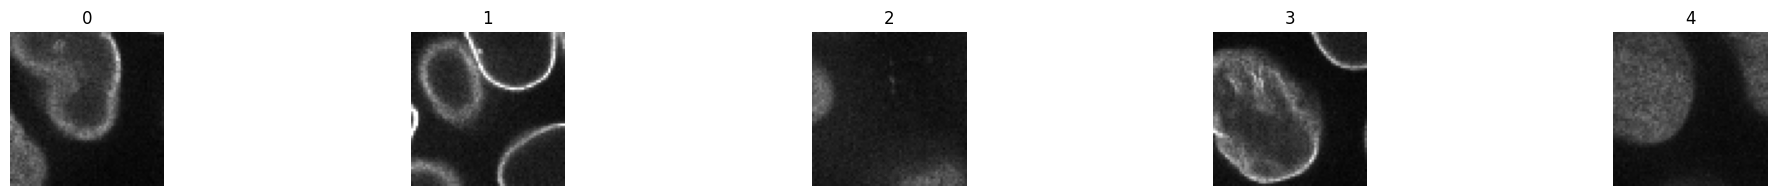

In [10]:
display_images(torch.tensor(BFbatch_val)[:,0,:,:,0], 1,5, range(5)) 
display_images(torch.tensor(FLbatch_val)[:,0,:,:,0], 1,5, range(5))

In [11]:
#########  TRAINING #################
print('started')
n_epochs = 4000
scaler = GradScaler()
augment_data = True
loss_TH = 100
batch_size = 4

for epoch in range(n_epochs):
    epoch_loss = 0
    # for step, data in enumerate(train_loader):
    for step in range(10):
        # break
        model.train()
        BF_images, GT_images = run_augmentations(BF_images, GT_images) 
        DiffModel.optimizer.zero_grad(set_to_none=True)
        
        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(GT_images).to(device)
            timesteps = torch.randint(0, DiffModel.tsteps, (len(BF_images),)).to(device) 
            noisy_GT_images = DiffModel.scheduler.add_noise(original_samples=GT_images.to(device) , noise=noise, timesteps=timesteps) 
            combined = torch.cat((BF_images.to(device) , noisy_GT_images.to(device) ), dim=1)
            prediction = model(x=combined, timesteps=timesteps) 
            # Get model prediction
            loss = torch.abs( prediction.float() - noise.float() )
            loss = loss.mean()
        scaler.scale(loss).backward()
        scaler.step(DiffModel.optimizer)
        scaler.update()
        epoch_loss += loss.item()
    
    ### END of EPOCH
    print('epoch ' + str(epoch))
    
    ############# TEST ###############################################################
    FL_preds_val, all_pred_orig_val, _, _ = predict_FL(DiffModel, BF_images, 200 , 800, seed=42) 
    
    ### metrics on 3D avg 
    
    rn = 4 ## for  rounding
    print('')
    print('---------------------------')
    print('I2I similarity metrics')
    print('---------------------------')

    GT_DDPM_pcc_agg       = pcc(FLbatch_val , FL_preds_val   , rn) 
    GT_DDPMavg_pcc_agg    = pcc(FLbatch_val , all_pred_orig_val, rn) 

    GT_DDPM_mse_agg       = mse(FLbatch_val , FL_preds_val   , rn)  
    GT_DDPMavg_mse_agg    = mse(FLbatch_val , all_pred_orig_val, rn)  
      
    GT_DDPM_MSssim_agg    = ms_ssim(FLbatch_val[:,0,...].transpose(0,3,1,2) , FL_preds_val[:,0,...].transpose(0,3,1,2)   , rn)       
    GT_DDPMavg_MSssim_agg = ms_ssim(FLbatch_val[:,0,...].transpose(0,3,1,2) , all_pred_orig_val[:,0,...].transpose(0,3,1,2), rn)   
     
    print('')
    print( 'pcc    : ' , GT_DDPM_pcc_agg , ' ' , GT_DDPMavg_pcc_agg)
    print( 'mse    : ' , GT_DDPM_mse_agg , ' ' , GT_DDPMavg_mse_agg)
    print( 'MSssim : ' , GT_DDPM_MSssim_agg , ' ' , GT_DDPMavg_MSssim_agg)

    
    ### save model
    # torch.save( model.state_dict(), main_path + "saved_models/" + organelle + "/mymodel.pth")
     

started
epoch 0

---------------------------
I2I similarity metrics
---------------------------

pcc    :  -0.0012   -0.001
mse    :  0.2851   0.2593
MSssim :  0.0448   0.0515
epoch 1


KeyboardInterrupt: 